<a href="https://colab.research.google.com/github/Sachinsachin21/GAN/blob/main/GAN_Scratch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 30.6 MB/s eta 0:00:00


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torchvision.datasets as ds
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(devices)

cuda


In [4]:
random_seed = 42
if devices.type == 'cuda':
    torch.cuda.manual_seed_all(random_seed)
batch_size = 128
avail_gpu = 1 if torch.cuda.is_available() else 0
num_works = int(os.cpu_count()/2)

In [5]:
class MNIST(pl.LightningDataModule):
  def __init__(self, data_dir = "./data",
               batch_size = batch_size, num_workers = num_works):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_works
    self.transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )
  def prepare_data(self):
    torchvision.datasets.MNIST(self.data_dir, train = True, download = True)
    torchvision.datasets.MNIST(self.data_dir, train = False, download = True)
  def setup(self, stage= None):
    if stage == "fit" or stage is None:
      mnist_full = torchvision.datasets.MNIST(self.data_dir, train = True, transform = self.transforms)
      self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    if stage == "test" or stage is None:
      self.mnist_test = torchvision.datasets.MNIST(self.data_dir, train = False, transform = self.transforms)

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size = self.batch_size, num_workers = self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size = self.batch_size, num_workers = self.num_workers)

In [6]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10,20, kernel_size =5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 1)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)

In [7]:
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.l1 = nn.Linear(latent_dim, 7*7*64)
    self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride = 2, padding=1)
    self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride = 2, padding=1)
    self.conv = nn.Conv2d(16,1, kernel_size = 7, padding=3)

  def forward(self,x):
    x = self.l1(x)
    x = F.relu(x)
    x = x.view(-1, 64, 7, 7)
    x = self.ct1(x)
    x = F.relu(x)
    x = self.ct2(x)
    x = F.relu(x)
    return torch.tanh(self.conv(x))

In [8]:
class GAN(pl.LightningModule):
  def __init__(self, latent_dim = 100, lr = 0.0002):
    super(GAN, self).__init__()
    self.save_hyperparameters()
    self.generator = Generator(latent_dim = self.hparams.latent_dim)
    self.discriminator = Discriminator()
    self.val = torch.randn(6, self.hparams.latent_dim)
    self.automatic_optimization = False

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx):
    real_img, _ = batch
    z = torch.randn(real_img.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_img)

    opt_g, opt_d = self.optimizers()

    fake_img = self(z)
    y_hat = self.discriminator(fake_img)
    y = torch.ones(real_img.size(0), 1)
    y = y.type_as(real_img)
    g_loss = self.adversarial_loss(y_hat, y)

    opt_g.zero_grad()
    self.manual_backward(g_loss)
    opt_g.step()

    y_hat_real = self.discriminator(real_img)
    y_real = torch.ones(real_img.size(0), 1).type_as(real_img)
    real_loss = self.adversarial_loss(y_hat_real, y_real)

    y_hat_fake = self.discriminator(self(z).detach())
    y_fake = torch.zeros(real_img.size(0), 1)
    y_fake = y_fake.type_as(real_img)

    fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
    d_loss = (real_loss + fake_loss) / 2

    opt_d.zero_grad()
    self.manual_backward(d_loss)
    opt_d.step()

    log_dict = {"g_loss": g_loss, "d_loss": d_loss}
    return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}

  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(),lr =lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(),lr =lr)
    return [opt_g, opt_d], []

  def plot_img(self):
    z = torch.randn(6, self.hparams.latent_dim)
    z = z.type_as(self.generator.l1.weight)
    samp_img = self(z).cpu()

    print("Epoch",self.current_epoch)
    fig = plt.figure()
    for i in range(samp_img.size(0)):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(samp_img.detach()[i,0,:,:], cmap = "gray_r", interpolation = "none")
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis("off")
    plt.show()

  def on_epoch_end(self):
    self.plot_img()

In [9]:
dm = MNIST()
model = GAN()

Epoch 0


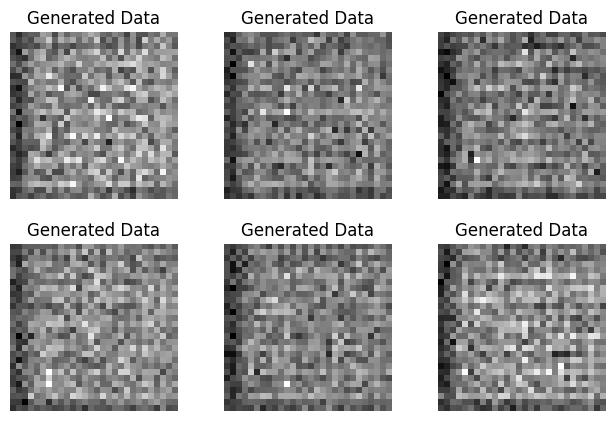

In [10]:
model.plot_img()

In [11]:
trainer = pl.Trainer(max_epochs = 21, accelerator = "gpu", devices = avail_gpu)
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 514kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.34MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.51MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=21` reached.


Epoch 21


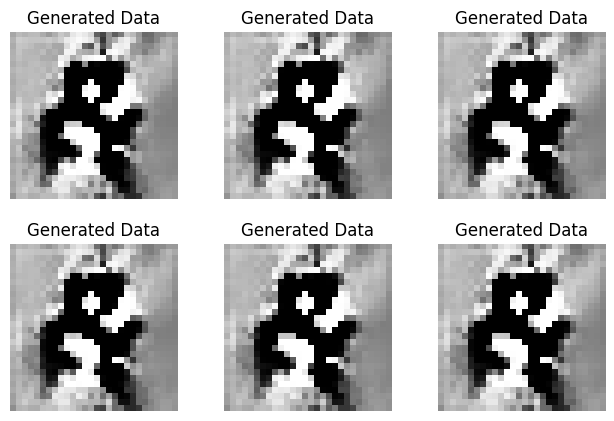

In [12]:
model.plot_img()